In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import sklearn
import sklearn.linear_model as lm
import sklearn.cross_validation as cv
import sklearn.grid_search as gs

%matplotlib inline

In [3]:
%pwd

u'/Users/antuanweeks/PythonCode/GA_DataScience/lesson-11'

In [12]:
titanic_raw = pd.read_csv('/Users/antuanweeks/PythonCode/GA_DataScience/lesson-11/datasets/titanic.csv')

titanic_raw.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
# Focus on key features

titanic = titanic_raw.drop(['ticket', 'cabin', 'name', 'fare', 'embarked', 'sibsp', 'parch'], axis=1)

titanic['sex'] = titanic['sex'] == 'female'
titanic.head()

,survived,pclass,sex,age
0,0,3,False,22.0
1,1,1,True,38.0
2,1,3,True,26.0
3,1,1,True,35.0
4,0,3,False,35.0


In [14]:
pd.crosstab(titanic.survived, titanic.sex)

sex,False,True
survived,,
0,468,81
1,109,233


In [15]:
pd.crosstab(titanic.survived, titanic.pclass)

pclass,1,2,3
survived,,,
0,80,97,372
1,136,87,119


In [16]:
data = titanic[['sex', 'age', 'pclass', 'survived']].copy()
data = data.dropna()

In [27]:
data_np = data.astype(np.int32).values #converts to numpy array of values

In [28]:
data_np

array([[ 0, 22,  3,  0],
       [ 1, 38,  1,  1],
       [ 1, 26,  3,  1],
       ..., 
       [ 1, 19,  1,  1],
       [ 0, 26,  1,  1],
       [ 0, 32,  3,  0]], dtype=int32)

In [29]:
# Note slicing from [:, :-1] here means from the 0th to 2nd to last row. (data_np[-1] access the last row)
X = data_np[:, :-1]
y = data_np[:,-1]

In [30]:
female = X[:,0] == 1
survived = y == 1
age = X[:, 1]

bins_ = np.arange(0, 81, 5)

# Split Survivors by gender and age
# Survivors ~ gender + age

# Survivors
S = {
    'male': np.histogram(age[survived & ~female], bins=bins_)[0],
    'female': np.histogram(age[survived & female], bins=bins_)[0]
}

# Non-Survivors
D = {
    'male': np.histogram(age[~survived & ~female], bins=bins_)[0],
    'female': np.histogram(age[~survived & female], bins=bins_)[0]
}

D

{'female': array([ 5,  6,  4,  7, 10, 10,  6,  4,  5,  5,  1,  1,  0,  0,  0,  0]),
 'male': array([ 8,  5,  5, 45, 65, 58, 49, 35, 25, 20, 17,  9,  9,  4,  6,  0])}

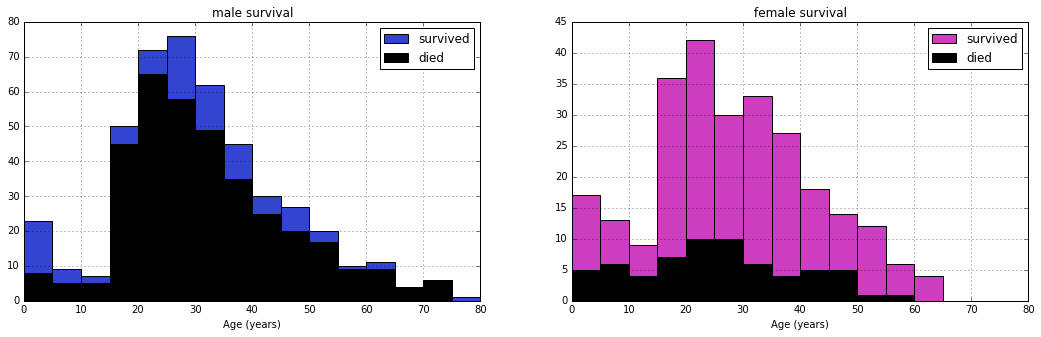

In [31]:
# We now plot the data.
bins = bins_[:-1]
plt.figure(figsize=(18, 5));
# for i, sex, color in [(0, 'male', '#3345d0'), (1, 'female', '#cc3dc0')]:

# TODO: Think about how we could rewrite the following using a for loop to avoid repetition

plt.subplot(121);
plt.bar(bins, S['male'], bottom=D['male'], color='#3345d0', width=5, label='survived');
plt.bar(bins, D['male'], color='k', width=5, label='died');
plt.xlim(0, 80);
plt.grid(None);
plt.title('male' + " survival");
plt.xlabel("Age (years)");
plt.legend();

plt.subplot(122);
plt.bar(bins, S['female'], bottom=D['female'], color='#cc3dc0', width=5, label='survived');
plt.bar(bins, D['female'], color='k', width=5, label='died');
plt.xlim(0, 80);
plt.grid(None);
plt.title('female' + " survival");
plt.xlabel("Age (years)");
plt.legend();

In [32]:
# We split X and y into train and test datasets. 
#  Note: I don't have much data here so use 95% of my data points for training
X_train, X_test, y_train, y_test = cv.train_test_split(X, y, test_size=.05)

In [33]:
# We instantiate the classifier in a similar manner to LinearRegression
logreg = lm.LogisticRegression();

logreg.fit(X_train, y_train)
y_predicted = logreg.predict(X_test)

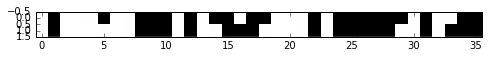

In [34]:
plt.figure(figsize=(8, 3))

plt.imshow(np.vstack((y_test, y_predicted)), interpolation='none', cmap='bone')

In [35]:
cv.cross_val_score(logreg, X, y)

array([ 0.78661088,  0.78991597,  0.78059072])

In [36]:
grid = gs.GridSearchCV(logreg, {'C': np.logspace(-5, 5, 200)}, n_jobs=4)
grid.fit(X_train, y_train);
grid.best_params_

{'C': 0.18679135990207846}

In [59]:
cv.cross_val_score(grid.best_estimator_, X, y)

array([ 0.77405858,  0.81092437,  0.79746835])

# With a nonlinear decision boundary

In [60]:
from sklearn.preprocessing import PolynomialFeatures

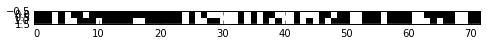

In [61]:
# fit a 4th order polynomial
poly = PolynomialFeatures(degree=3)
poly.fit(X)

X_poly = poly.transform(X)

X_poly_train, X_poly_test, y_poly_train, y_poly_test = cv.train_test_split(X_poly, y, test_size=.1)

logreg.fit(X_poly_train, y_poly_train)
y_poly_predicted = logreg.predict(X_poly_test)

plt.figure(figsize=(8, 3))

plt.imshow(np.vstack((y_poly_test, y_poly_predicted)), interpolation='none', cmap='bone')

In [62]:
cv.cross_val_score(logreg, X_poly, y, cv=10)

array([ 0.76388889,  0.73611111,  0.76388889,  0.875     ,  0.77464789,
        0.8028169 ,  0.77464789,  0.74647887,  0.84507042,  0.81690141])

In [63]:
grid = gs.GridSearchCV(logreg, {'C': np.logspace(-5, 5, 200)}, n_jobs=4)
grid.fit(X_poly_train, y_poly_train);
grid.best_params_

{'C': 1382.6221737646592}

In [64]:
cv.cross_val_score(grid.best_estimator_, X, y)

array([ 0.78242678,  0.79831933,  0.78481013])

In [65]:
## This function is used to plot the decision boundary in two dimensions. We haven't covered some of this stuff yet, 
# and while useful, focus on the rest of this code in this notebook before reviewing this function.
def plot_decision_boundary(est, x_1, x_2, ax=None, threshold=0.0, contourf=False):
    """Plots the decision surface of ``est`` on features ``x1`` and ``x2``. """
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))
    # plot the hyperplane by evaluating the parameters on the grid
    X_pred = np.c_[xx1.ravel(), xx2.ravel()]  # convert 2d grid into seq of points
    if hasattr(est, 'predict_proba'):  # check if ``est`` supports probabilities
        # take probability of positive class
        pred = est.predict_proba(X_pred)[:, 1]
    else:
        pred = est.predict(X_pred)
    Z = pred.reshape((100, 100))  # reshape seq to grid
    if ax is None:
        ax = plt.gca()

    # plot line via contour plot

    if contourf:
        ax.contourf(xx1, xx2, Z, levels=np.linspace(0, 1.0, 10), cmap=plt.cm.RdBu, alpha=0.6)
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))